In [1]:
import sys
import os
import pandas as pd
from sqlalchemy import create_engine, text
sys.path.append(os.path.abspath(".."))
from db.db_config import ORACLE_CONFIG

from sqlalchemy import create_engine, text
from db.db_config import ORACLE_CONFIG

# Create the engine using correct PDB DSN
engine = create_engine(
    f"oracle+oracledb://{ORACLE_CONFIG['user']}:{ORACLE_CONFIG['password']}@{ORACLE_CONFIG['dsn']}"
)

with engine.connect() as conn:
    print(" Connected as:", conn.execute(text("SELECT user FROM dual")).scalar())
    print(" PDB Name:", conn.execute(text("SELECT sys_context('userenv', 'con_name') FROM dual")).scalar())

    print("\n Checking if BANK_REVIEWS table exists in MY schema...\n")

    result = conn.execute(text("""
        SELECT object_name, object_type, status 
        FROM user_objects 
        WHERE object_name = 'BANK_REVIEWS'
    """)).fetchall()

    if result:
        for row in result:
            print(f" Found: {row.object_name}, Type: {row.object_type}, Status: {row.status}")
    else:
        print(" No table named BANK_REVIEWS found in current schema.")

    print("\n Trying SELECT COUNT(*) FROM BANK_REVIEWS directly...\n")

    try:
        count = conn.execute(text("SELECT COUNT(*) FROM BANK_REVIEWS")).scalar()
        print(f" Success! Row count: {count}")
    except Exception as e:
        print(f" Failed to access table directly: {e}")



 Connected as: SYSTEM
 PDB Name: XEPDB1

 Checking if BANK_REVIEWS table exists in MY schema...

 Found: BANK_REVIEWS, Type: TABLE, Status: VALID

 Trying SELECT COUNT(*) FROM BANK_REVIEWS directly...

 Success! Row count: 849


In [3]:
df = pd.read_sql("SELECT * FROM system.bank_reviews", con=engine)
for col in df.columns:
    if df[col].apply(lambda x: hasattr(x, 'read')).any():
        df[col] = df[col].apply(lambda x: x.read() if hasattr(x, 'read') else x)

df.head()

,review,rating,review_date,bank,source,sentiment_label,sentiment_score
0,A great app. It's like carrying a bank in your...,4,2025-06-07,Commercial Bank of Ethiopia,Google Play,POSITIVE,0.999293
1,More than garrantty bank EBC.,4,2025-06-07,Commercial Bank of Ethiopia,Google Play,POSITIVE,0.997196
2,really am happy to this app it is Siple to use...,5,2025-06-07,Commercial Bank of Ethiopia,Google Play,POSITIVE,0.998870
3,I liked this app. But the User interface is ve...,2,2025-06-07,Commercial Bank of Ethiopia,Google Play,NEGATIVE,0.999684
4,"""Why don’t your ATMs support account-to-accoun...",4,2025-06-06,Commercial Bank of Ethiopia,Google Play,NEGATIVE,0.996465


In [ ]:
#data preprocessing
df['rating'] = df['rating'].astype(int)
df['sentiment_score'] = df['sentiment_score'].astype(float)
df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')
df['sentiment_label'] = df['sentiment_label'].str.lower().str.strip()


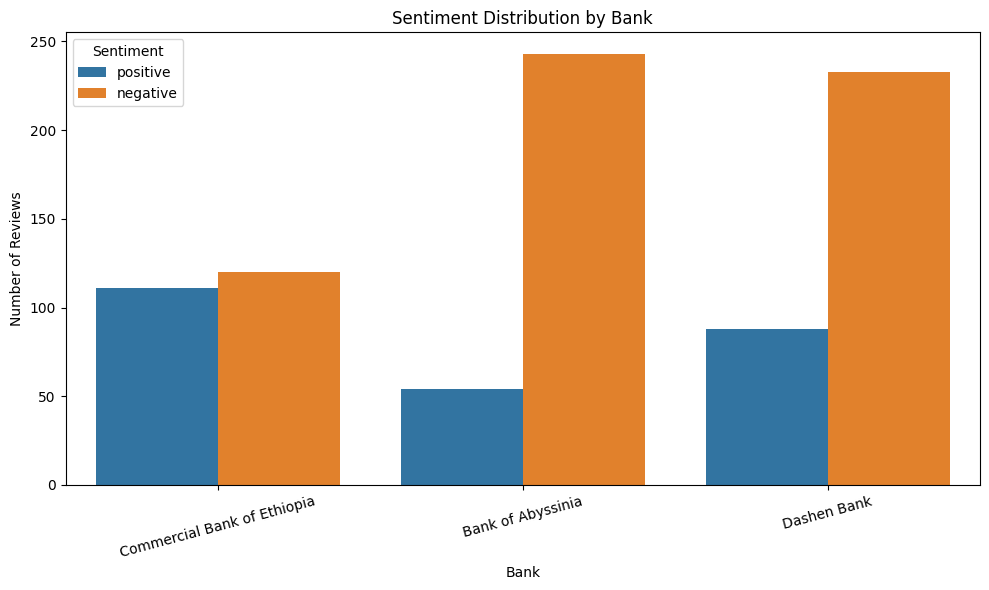

In [6]:
#sentiment  distribution by bank
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='bank', hue='sentiment_label')
plt.title("Sentiment Distribution by Bank")
plt.xlabel("Bank")
plt.ylabel("Number of Reviews")
plt.legend(title="Sentiment")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


/tmp/ipykernel_229086/3191060681.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='rating', y='sentiment_score', hue='bank', ci=None)


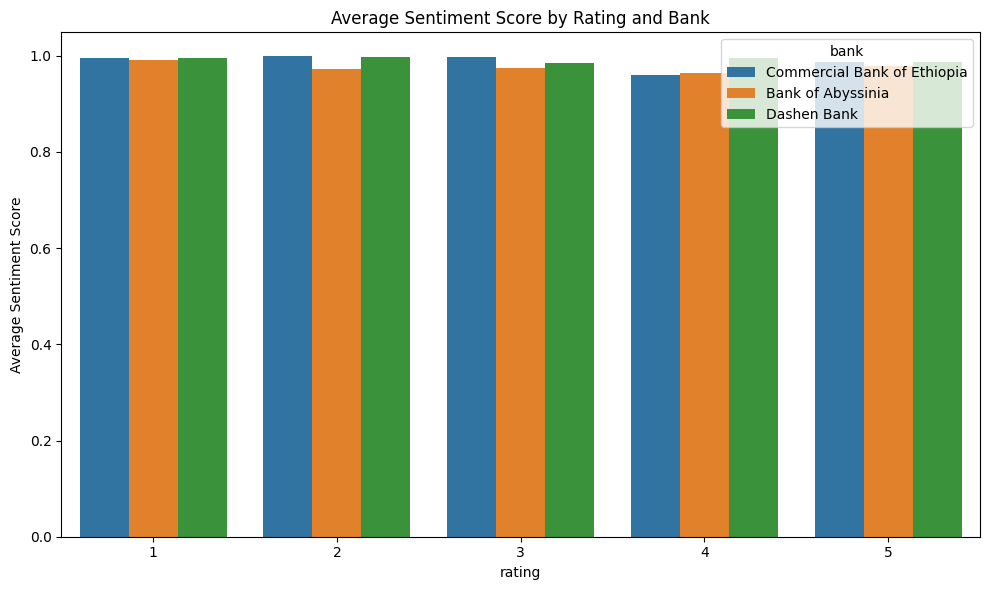

In [ ]:
#average sentiment score by rating 
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='rating', y='sentiment_score', hue='bank', errorbar=None)
plt.title("Average Sentiment Score by Rating and Bank")
plt.ylabel("Average Sentiment Score")
plt.tight_layout()
plt.show()



In [ ]:
#insights summary 
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='theme', hue='bank', order=df['theme'].value_counts().index)
plt.title("Top Themes by Bank")
plt.xlabel("Review Count")
plt.ylabel("Theme")
plt.tight_layout()
plt.show()


KeyError: 'theme'

<Figure size 1200x600 with 0 Axes>

In [9]:
#insights summary 
print(" Insight Summary:\n")
for bank in df['bank'].unique():
    bank_df = df[df['bank'] == bank]
    top_theme = bank_df['theme'].value_counts().idxmax()
    avg_score = bank_df['sentiment_score'].mean()
    print(f"- {bank}:\n"
          f"  • Most mentioned theme: {top_theme}\n"
          f"  • Average sentiment score: {avg_score:.2f}\n")


 Insight Summary:



KeyError: 'theme'